In [1]:
import torch
import torchvision
from torch import nn
from torch import optim
from torchvision import datasets
from torchvision.transforms import v2 as T
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
def plot_image(tensor):
    plt.figure(figsize=(1.25, 1.25))
    plt.axis('off')
    plt.imshow(tensor.permute(1, 2, 0).numpy())

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(128)

        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bnorm2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bnorm3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 3, kernel_size=3, padding=1)

        self.lrelu = nn.LeakyReLU()
        self.sigm = nn.Sigmoid()
        

    def forward(self, x):
        x = self.lrelu(self.conv1(x))
        x = self.bnorm1(x)

        x = self.lrelu(self.conv2(x))
        x = self.bnorm2(x)

        x = self.lrelu(self.conv3(x))
        x = self.bnorm3(x)
        
        x = self.sigm(self.conv4(x))
        return x

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.bnorm1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 16, kernel_size=5)
        self.bnorm2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 8, kernel_size=5)
        self.bnorm3 = nn.BatchNorm2d(8)

        self.conv4 = nn.Conv2d(8, 4, kernel_size=5)
        self.bnorm4 = nn.BatchNorm2d(4)

        self.conv5 = nn.Conv2d(4, 2, kernel_size=5)
        self.bnorm5 = nn.BatchNorm2d(2)

        self.conv6 = nn.Conv2d(2, 1, kernel_size=5)

        self.fc = nn.Linear(64, 1)

        self.lrelu = nn.LeakyReLU()
        self.sigm = nn.Sigmoid()

    def forward(self, x, t):
        x = self.lrelu(self.conv1(x))
        x = self.bnorm1(x)

        x = self.lrelu(self.conv2(x))
        x = self.bnorm2(x)

        x = self.lrelu(self.conv3(x))
        x = self.bnorm3(x)

        x = self.lrelu(self.conv4(x))
        x = self.bnorm4(x)

        x = self.lrelu(self.conv5(x))
        x = self.bnorm5(x)

        x = self.lrelu(self.conv6(x))

        x = x.view(x.size(0), -1)

        x = self.sigm(self.fc(x))
        return x

In [5]:
mean = torch.tensor([0.49139968, 0.48215827 ,0.44653124])
std = torch.tensor([0.24703233, 0.24348505, 0.26158768])
transform = T.Compose([
    T.ToImage(),
    # T.Resize(size=(32, 32), antialias=True),
    T.ToDtype(torch.float32, scale=True),
    # T.Normalize(mean=mean, std=std),
])

In [6]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform

train_data = datasets.CIFAR10(
    root="data",
    download=True,
    transform=transform
)

train_loader = DataLoader(dataset=train_data, batch_size=512, shuffle=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 53894151.46it/s]


Extracting data\cifar-10-python.tar.gz to data


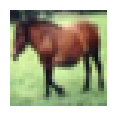

In [7]:
plot_image(train_data[7][0])

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(params=model.parameters(), lr=1e-3, weight_decay=1e-3)

In [ ]:
num_epochs = 500
losses = []
for epoch in tqdm(range(num_epochs)):
    plt.figure(figsize=(10, 10))
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(bottom=0.0) # , top=0.8)
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.1))  # Major ticks every 0.1
    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.01))  # Minor ticks every 0.01
    plt.grid(which='both', axis='y')
    plt.show()

    model.train()
    avg_loss = 0
    for images, _ in train_loader:
        t = torch.randint(0, time, (len(images),))
        noisy_images, noise = forward_diffuse(images, t)
        noisy_images, noise = noisy_images.to(device), noise.to(device)
            
        output = model(noisy_images, t.to(device))
        loss = criterion(output, noise)
        avg_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = avg_loss / len(train_loader)
    losses.append(avg_loss)
    plt.plot(losses, marker='o', linestyle='-', color='b', label='Loss')
    clear_output(wait=True)

In [ ]:
with torch.no_grad():
    test_image = torch.randn((1, 3, 32, 32)).to(device)
    plot_image(test_image[0].cpu())
    for t in range(time):
        noise = model(test_image, torch.tensor([t]).to(device))
        alpha = schedule[t]
        test_image = (test_image - torch.sqrt(1 - alpha) * noise) / torch.sqrt(alpha)
        plot_image(test_image[0].cpu())